In [1]:
import os
import re
import ast
import math
import time
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style

from glob import glob
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
import tensorflow.keras as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D 
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten, Activation

warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)

Using TensorFlow backend.


In [3]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
label = "The_Great_Wall_of_China"

input_csv_file = 'drive/My Drive/input/train/The Great Wall of China.csv'

dir_to_save_model = "drive/My Drive/Colab Notebooks/gan/"+label+"/"

num_examples = 100

In [0]:
imheight, imwidth = 64, 64
ims_per_class = 200000
width = 5

def draw_it_(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width = width)
    image = image.resize((imheight, imwidth))
    return np.array(image)/-127.5 + 1

In [24]:
train = pd.read_csv(input_csv_file, nrows=ims_per_class)
imagebag = bag.from_sequence(train.drawing.values).map(draw_it_) 
trainarray = np.array(imagebag.compute())
print(trainarray.shape)
X_train = trainarray.reshape(trainarray.shape[0], imheight, imwidth, 1)
print(X_train.shape)


(153957, 64, 64)
(153957, 64, 64, 1)


[[[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [ 1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [ 1.]
  [ 1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [ 1.]
  [-1.]
  [-1.]]

 ...

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]]


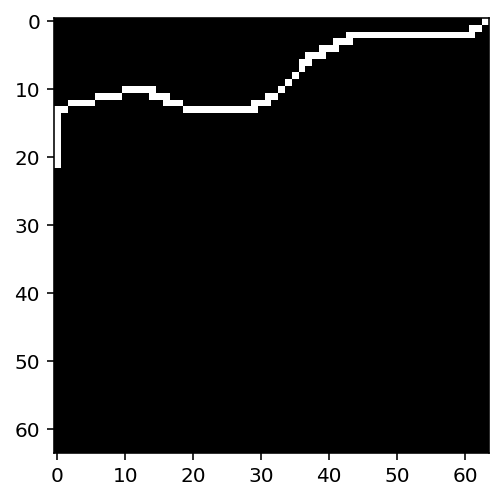

In [25]:
print(X_train[80])
a = X_train[80].reshape(imheight, imwidth)
plt.imshow(a, cmap='gray')


In [0]:
class DCGAN():
  
  def __init__(self):
      self.img_rows = imheight
      self.img_cols = imwidth
      self.img_shape = (self.img_rows, self.img_cols, 1)

      self.latent_dim = 100

      self.optimizer = Adam(0.0002, 0.5)

      self.discriminator = self.load_discriminator()
      self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      self.discriminator.summary()

      self.generator = self.load_generator()
      self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      self.generator.summary()

      self.gan = self.build_GAN()
  
  def build_GAN(self):

      self.discriminator.trainable = False
      gan_input = Input(shape=(self.latent_dim,))
      img = self.generator(gan_input)
      
      gan_output = self.discriminator(img)
      gan = Model(gan_input, gan_output, name='GAN')
      gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      gan.summary()
      
      return gan
    
  def load_generator(self):

      G = Sequential()
      G.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
      G.add(Reshape((8, 8, 128)))
      G.add(BatchNormalization(momentum=0.8))
      
      G.add(UpSampling2D())
      G.add(Conv2D(128, kernel_size=3, padding="same"))
      G.add(LeakyReLU(0.2))
      G.add(BatchNormalization(momentum=0.8))
      
      G.add(UpSampling2D())
      G.add(Conv2D(64, kernel_size=3, padding="same"))
      G.add(LeakyReLU(0.2))
      G.add(BatchNormalization(momentum=0.8))

      G.add(UpSampling2D())
      G.add(Conv2D(32, kernel_size=3, padding="same"))
      G.add(LeakyReLU(0.2))
      G.add(BatchNormalization(momentum=0.8))

      G.add(Conv2D(1, kernel_size=3, padding='same', activation = "tanh"))
      #G.summary()
      

      noise = Input(shape=(self.latent_dim,))
      img = G(noise)
      print(img.shape)

      return Model(noise, img, name='Generator')

  def load_discriminator(self):
 
      D = Sequential()
      D.add(Flatten())
      D.add(Dense(1024, kernel_initializer=RandomNormal(stddev=0.02)))
      D.add(LeakyReLU(0.2))
      D.add(Dropout(0.3))
      D.add(Dense(512))
      D.add(LeakyReLU(0.2))
      D.add(Dropout(0.3))
      D.add(Dense(256))
      D.add(LeakyReLU(0.2))
      D.add(Dropout(0.3))
      D.add(Dense(1, activation='sigmoid'))

      img = Input(shape=self.img_shape)
      validity = D(img)

      return Model(img, validity, name='Discriminator')
 

  def train(self, X_train, epochs, batch_size=128, sample_interval=50):

      real = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))

      avg_losses = {'D': [], 'G': []}
      num_batches = len(X_train) // batch_size
      print(num_batches)
      
      for epoch in range(epochs):
          start_time = time.time()
          d_loss_acc = 0
          g_loss_acc = 0
          for i in range(num_batches):
            
            imgs = X_train[np.random.randint(0, len(X_train) - 1, batch_size)]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            self.discriminator.trainable = True

            d_loss_real = self.discriminator.train_on_batch(imgs, real * (np.random.uniform(0.7, 1.2)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake + (np.random.uniform(0.0, 0.3)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False
            
            g_loss = self.gan.train_on_batch(noise, real)            
            
            d_loss_acc += d_loss
            g_loss_acc += g_loss

          if (epoch + 1) % sample_interval == 0 or epoch == 0:
              self.sample_images(epoch)
              self.savemodel(epoch)

          avg_losses['D'].append(d_loss_acc/num_batches)
          avg_losses['G'].append(g_loss_acc/num_batches)
      
          end_time = time.time()  
          print("It cost : ", end_time - start_time)
      
      self.plot_loss(avg_losses)


  def sample_images(self, epoch):
    
    random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
    generated_images = self.generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples,imheight, imwidth)


    correct = 0

    for i in range(generated_images.shape[0]):
        
        
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

        grapharray = generated_images[i]


        for j in range(64):
            for k in range(64):
                if grapharray[j][k] < 0.2 : grapharray[j][k] = 1
                else: grapharray[j][k] = 0

        grapharray = np.reshape(grapharray, (1,64, 64, 1))
            
    
    plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
    plt.show()

  def plot_loss(self, losses):
     
      plt.figure(figsize=(10, 8))
      plt.plot(losses["D"], label="Discriminator loss")
      plt.plot(losses["G"], label="Generator loss")
   
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.title("Loss History")
      plt.show()

  def savemodel(self, epoch):
      self.generator.save(dir_to_save_model + label + str(epoch+1) + ".h5")

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 4851713   
Total params: 4,851,713
Trainable params: 4,851,713
Non-trainable params: 0
_________________________________________________________________
(?, 64, 64, 1)
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 64, 64, 1)         1068929   
Total params: 1,068,929
Trainable params: 1,068,225
Non-trainable params: 704
_______________________________________________________________

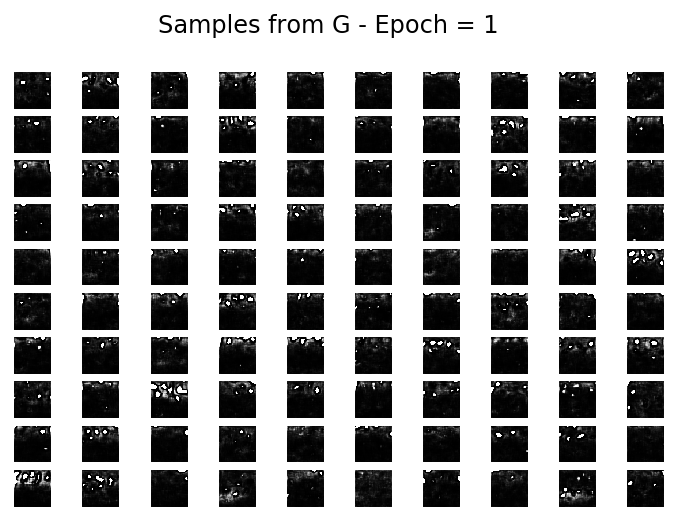

It cost :  87.61438131332397
It cost :  77.97699499130249
It cost :  78.01128458976746
It cost :  78.33760404586792


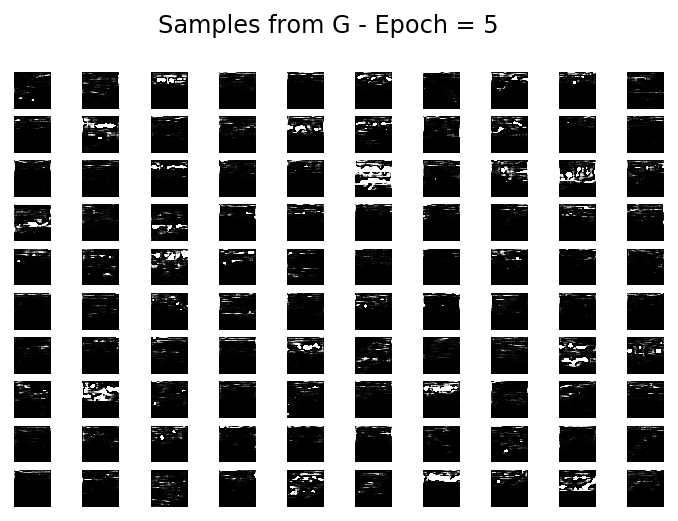

It cost :  81.56425309181213
It cost :  78.58554482460022
It cost :  77.67681980133057
It cost :  77.5792863368988
It cost :  77.67656207084656


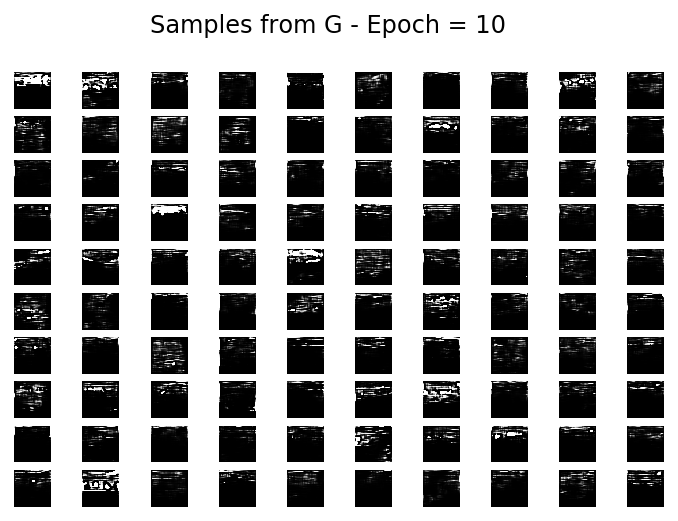

It cost :  80.20431470870972
It cost :  79.02472162246704
It cost :  77.50365877151489
It cost :  77.66488361358643
It cost :  77.48633813858032


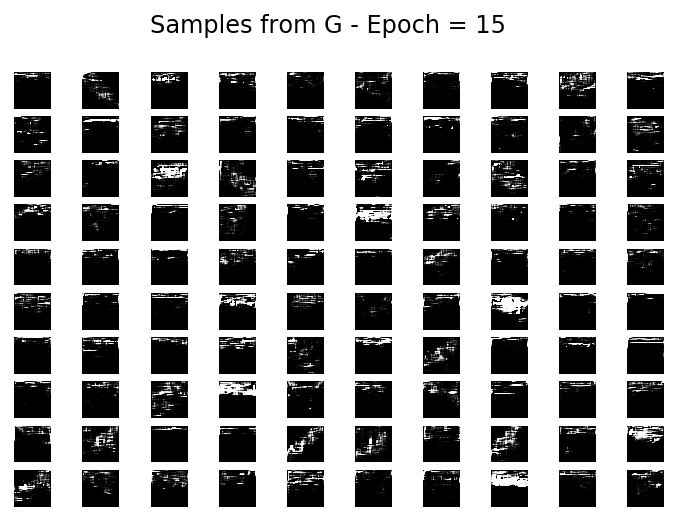

It cost :  80.19305205345154
It cost :  77.58256030082703
It cost :  77.75973987579346
It cost :  77.45884680747986
It cost :  77.46191835403442


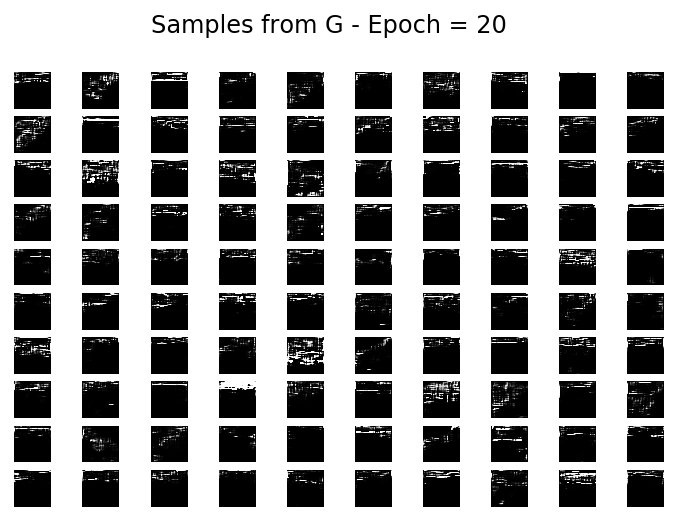

It cost :  80.54187250137329
It cost :  78.50217199325562
It cost :  77.42287063598633
It cost :  77.45176362991333
It cost :  77.5321455001831


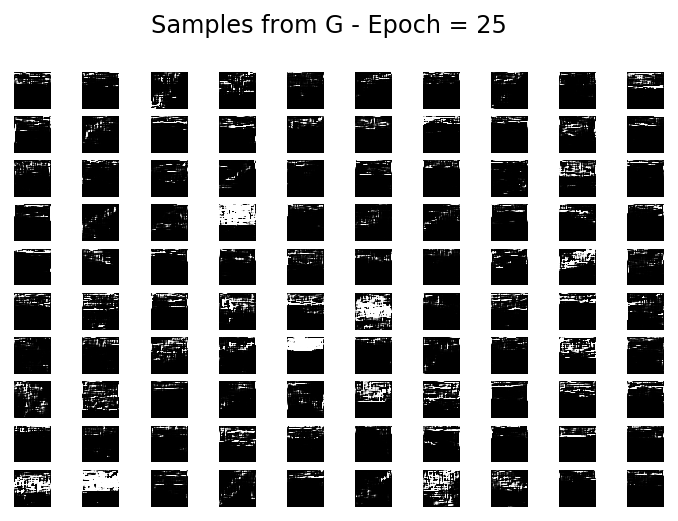

It cost :  80.52658200263977
It cost :  77.62715601921082
It cost :  77.38752102851868
It cost :  77.47942566871643
It cost :  77.83389711380005


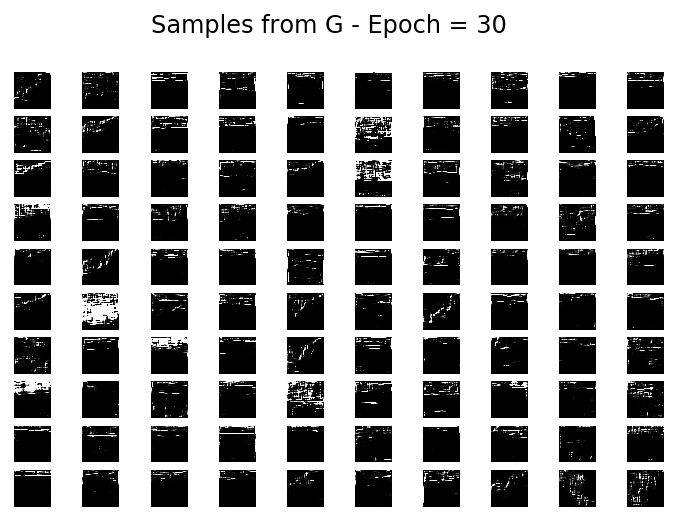

It cost :  80.24722862243652
It cost :  77.68097972869873
It cost :  77.71605324745178
It cost :  77.87490844726562
It cost :  77.6893196105957


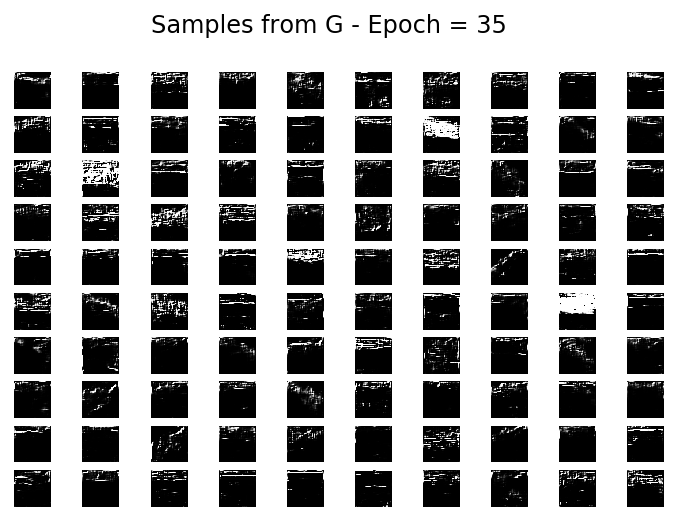

It cost :  80.38601994514465
It cost :  77.74455523490906
It cost :  77.90988087654114
It cost :  77.5297544002533
It cost :  77.46161484718323


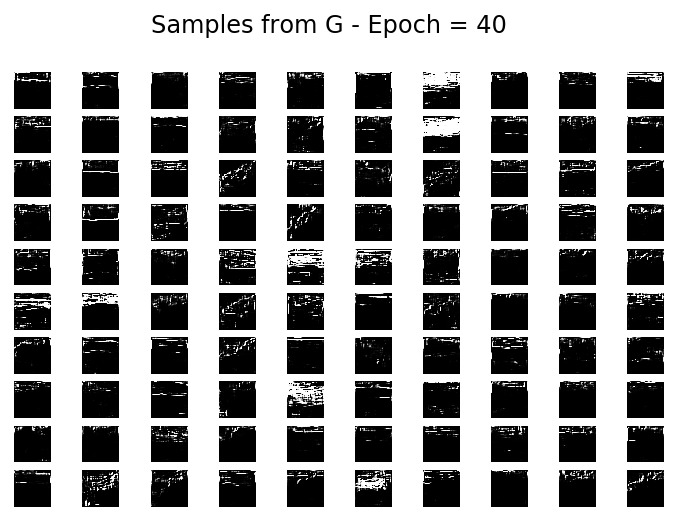

It cost :  80.26185584068298
It cost :  77.73572087287903
It cost :  77.54586124420166
It cost :  77.42908310890198
It cost :  77.6387586593628


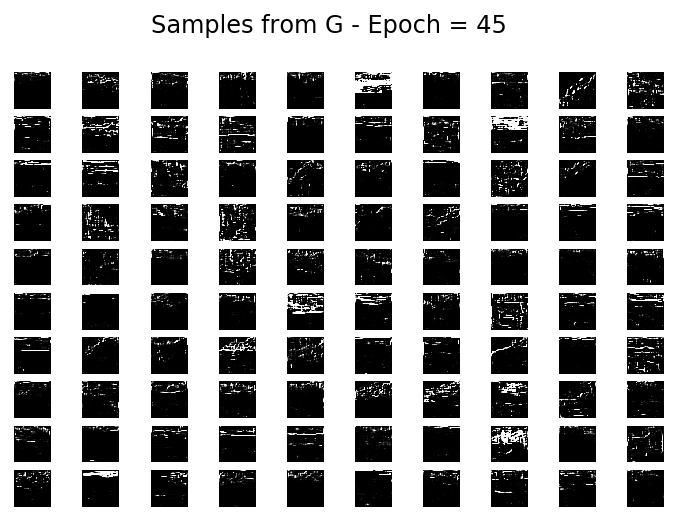

It cost :  80.34131479263306
It cost :  78.07069230079651
It cost :  78.20754027366638
It cost :  77.69357967376709
It cost :  77.90627551078796


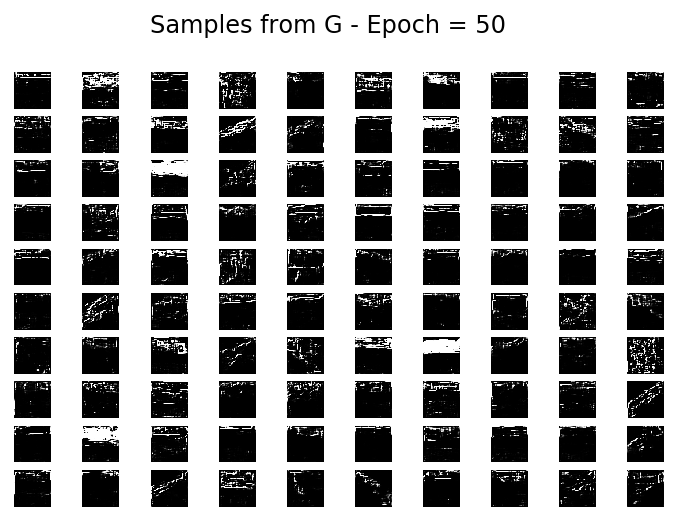

It cost :  80.44425344467163


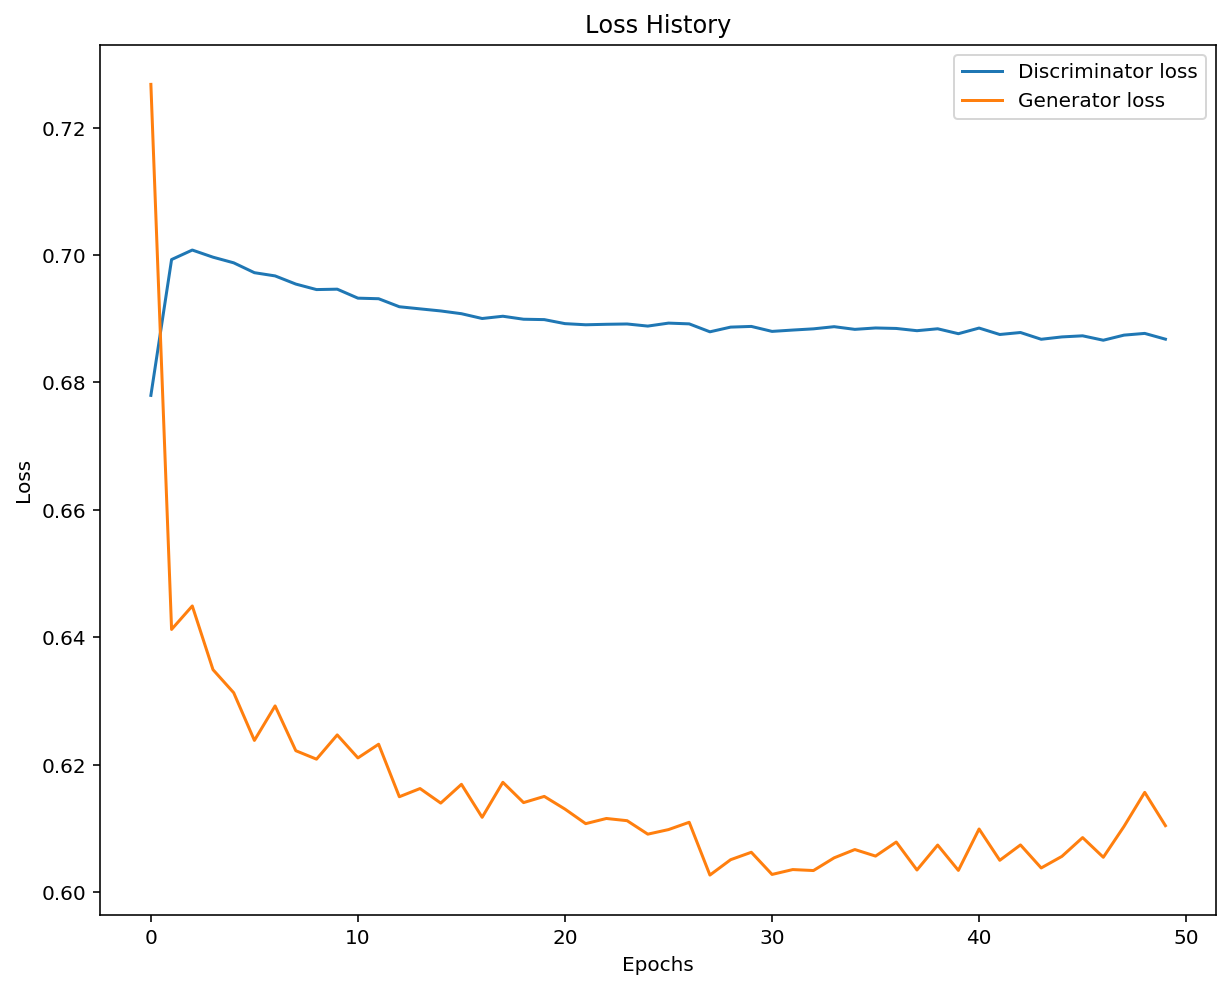

In [27]:
gan = DCGAN()
gan.train(X_train, epochs=50, batch_size=128, sample_interval=5)